## **Exploratory Data Analysis**

### **Library Imports**

In [30]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

pd.options.display.max_columns = None

### **Constants**

In [31]:
DATA_PATH = os.path.join('..', 'data', 'dev', '01_raw', 'diabetic_data.csv')

### **Data Imports**

In [32]:
raw_data = pd.read_csv(DATA_PATH)
display(raw_data.head())

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,Ch,Yes,1
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,Yes,0
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,Ch,Yes,0


### **EDA**

In [33]:
data = raw_data.copy()

In [34]:
data.shape

(101766, 27)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [36]:
data = data.replace('?', np.nan)
display(data.isnull().sum().sort_values(ascending=False))

# too many missing values
# weight                      98569
# max_glu_serum               96420
# A1Cresult                   84748
# medical_specialty           49949
# payer_code                  40256 => not insured, not really a null


data = data.drop(columns=[
    'weight',
    'max_glu_serum',
    'A1Cresult',
    'medical_specialty',
])

weight                      98569
max_glu_serum               96420
A1Cresult                   84748
medical_specialty           49949
payer_code                  40256
race                         2273
diag_3                       1423
diag_2                        358
diag_1                         21
encounter_id                    0
number_emergency                0
diabetesMed                     0
change                          0
number_diagnoses                0
number_inpatient                0
num_procedures                  0
number_outpatient               0
num_medications                 0
patient_nbr                     0
num_lab_procedures              0
time_in_hospital                0
admission_source_id             0
discharge_disposition_id        0
admission_type_id               0
age                             0
gender                          0
readmitted                      0
dtype: int64

In [37]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [38]:
ID_COLS = [
    'encounter_id',
    'patient_nbr'
]

TARGET_COL = 'readmitted'

NUMERIC_COLS = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses',
]

CATEGORICAL_COLS = [
    'race',
    'gender',
    'age',
    'payer_code',
    'admission_type_id',     
    'discharge_disposition_id',  
    'admission_source_id',        
    'diag_1',                    
    'diag_2',                    
    'diag_3',      
    'change',                    
    'diabetesMed',  
]

for col in CATEGORICAL_COLS:
    data[col] = data[col].astype('category')

for col in NUMERIC_COLS:
    data[col] = data[col].astype('float')

In [39]:
id_data = data[ID_COLS].copy()
target_data = data[TARGET_COL].copy()
num_data = data[NUMERIC_COLS].copy()
cat_data = data[CATEGORICAL_COLS].copy()

#### **Target**

In [40]:
target_data.value_counts(1)

0    0.539119
1    0.460881
Name: readmitted, dtype: float64

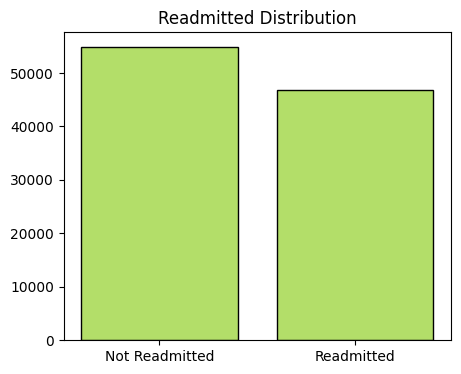

In [41]:
bar_color = '#b3de69'
plt.figure(figsize=(5, 4))
plt.bar(["Not Readmitted", "Readmitted"], target_data.value_counts().values,color=bar_color, edgecolor='black')
plt.title('Readmitted Distribution')
plt.show()

#### **IDs**

In [42]:
id_data.nunique()

# encounter_id is unique
# patient_nbr is not unique

encounter_id    101766
patient_nbr      71518
dtype: int64

In [43]:
(id_data.groupby('patient_nbr').count()
 .sort_values('encounter_id', ascending=False)
 .head(10))

,encounter_id
patient_nbr,
88785891,40
43140906,28
1660293,23
23199021,23
88227540,23
23643405,22
84428613,22
92709351,21
23398488,20


#### **Numeric**

In [44]:
num_data.describe().T

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,101766.0,4.395987,2.985108,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,101766.0,43.095641,19.674362,1.0,31.0,44.0,57.0,132.0
num_procedures,101766.0,1.339730,1.705807,0.0,0.0,1.0,2.0,6.0
num_medications,101766.0,16.021844,8.127566,1.0,10.0,15.0,20.0,81.0
number_outpatient,101766.0,0.369357,1.267265,0.0,0.0,0.0,0.0,42.0
number_emergency,101766.0,0.197836,0.930472,0.0,0.0,0.0,0.0,76.0
number_inpatient,101766.0,0.635566,1.262863,0.0,0.0,0.0,1.0,21.0
number_diagnoses,101766.0,7.422607,1.933600,1.0,6.0,8.0,9.0,16.0


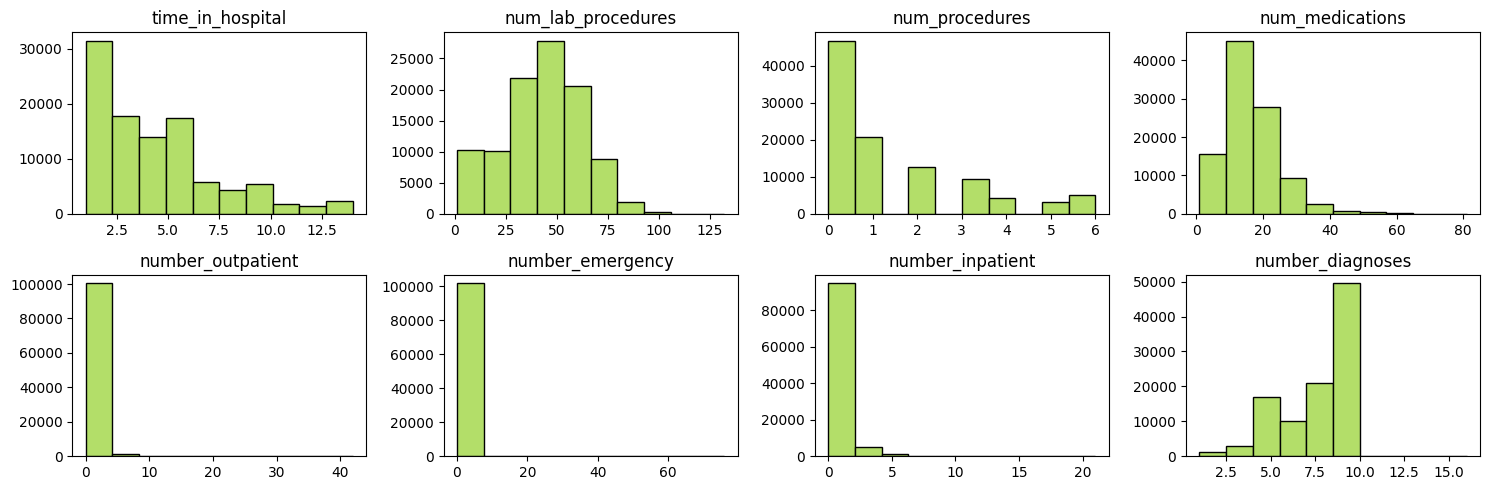

In [45]:
bar_color = '#b3de69'
plt.figure(figsize=(15, 5))
for i, col in enumerate(NUMERIC_COLS):
   plt.subplot(2, 4, i + 1)
   plt.hist(num_data[col],color=bar_color, edgecolor='black')
   plt.title(col)

plt.tight_layout()
plt.show()

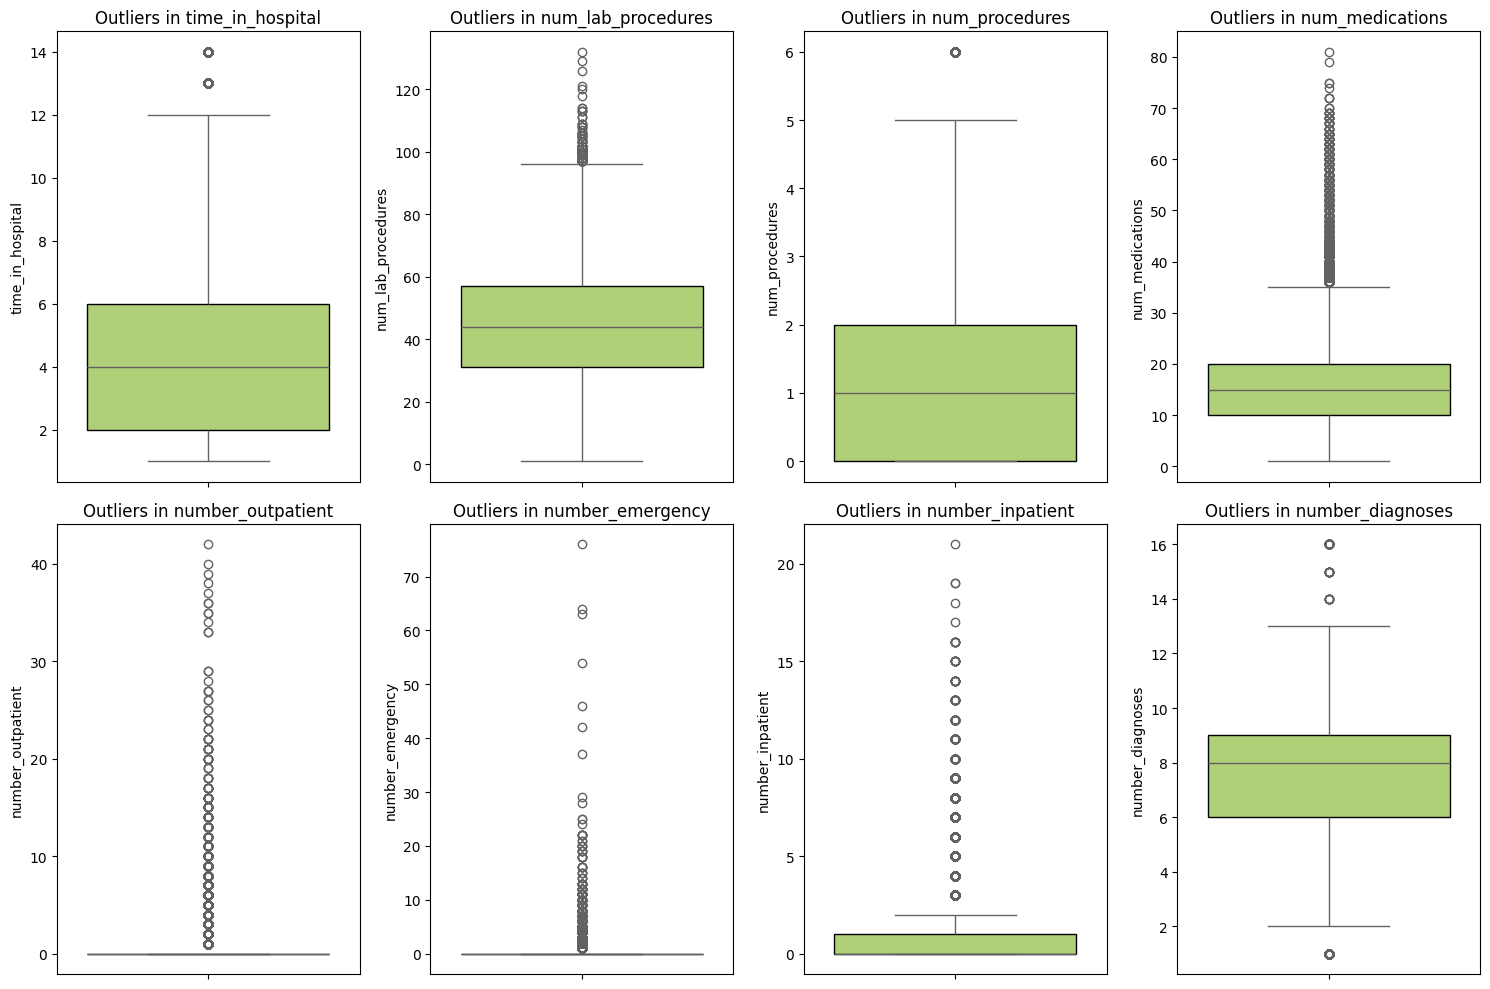

In [46]:
#Outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(NUMERIC_COLS, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=data[col], color=bar_color, boxprops=dict(edgecolor='black'))
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.show()

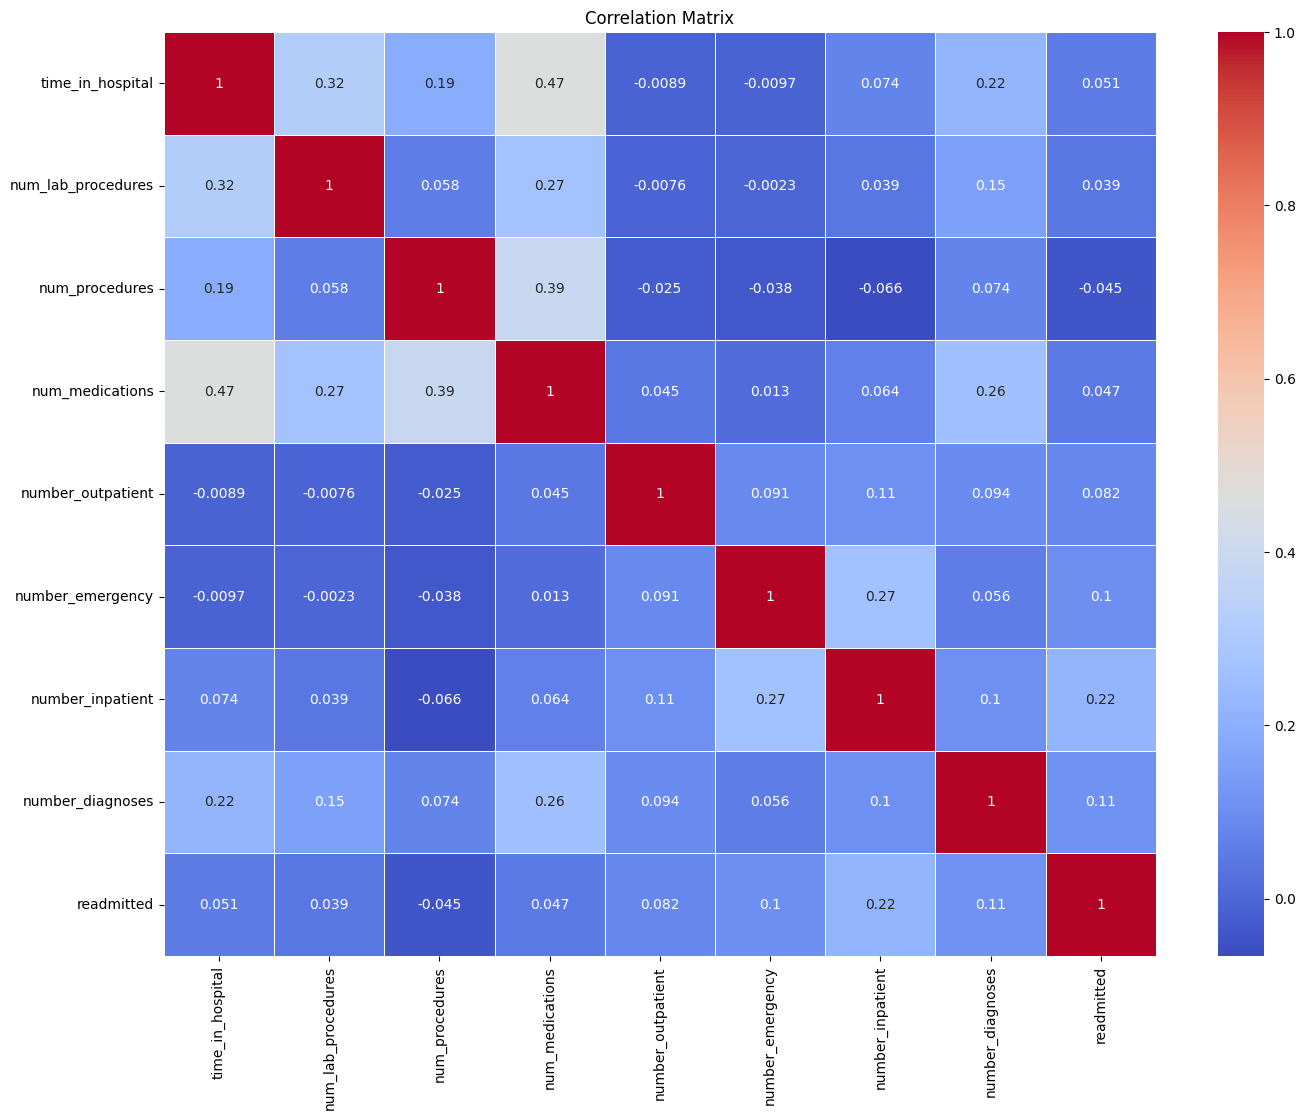

In [47]:
correlation_data = pd.concat([num_data, target_data], axis=1)

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### **Categorical**

In [48]:
cat_data.describe().T

,count,unique,top,freq
race,99493,5,Caucasian,76099
gender,101766,3,Female,54708
age,101766,10,[70-80),26068
payer_code,61510,17,MC,32439
admission_type_id,101766,8,1,53990
discharge_disposition_id,101766,26,1,60234
admission_source_id,101766,17,7,57494
diag_1,101745,716,428,6862
diag_2,101408,748,276,6752
diag_3,100343,789,250,11555


In [49]:
plotable_cat_data = []
for col in cat_data.columns:
    if cat_data[col].nunique() < 10:
        plotable_cat_data.append(col)

print(len(plotable_cat_data))

5


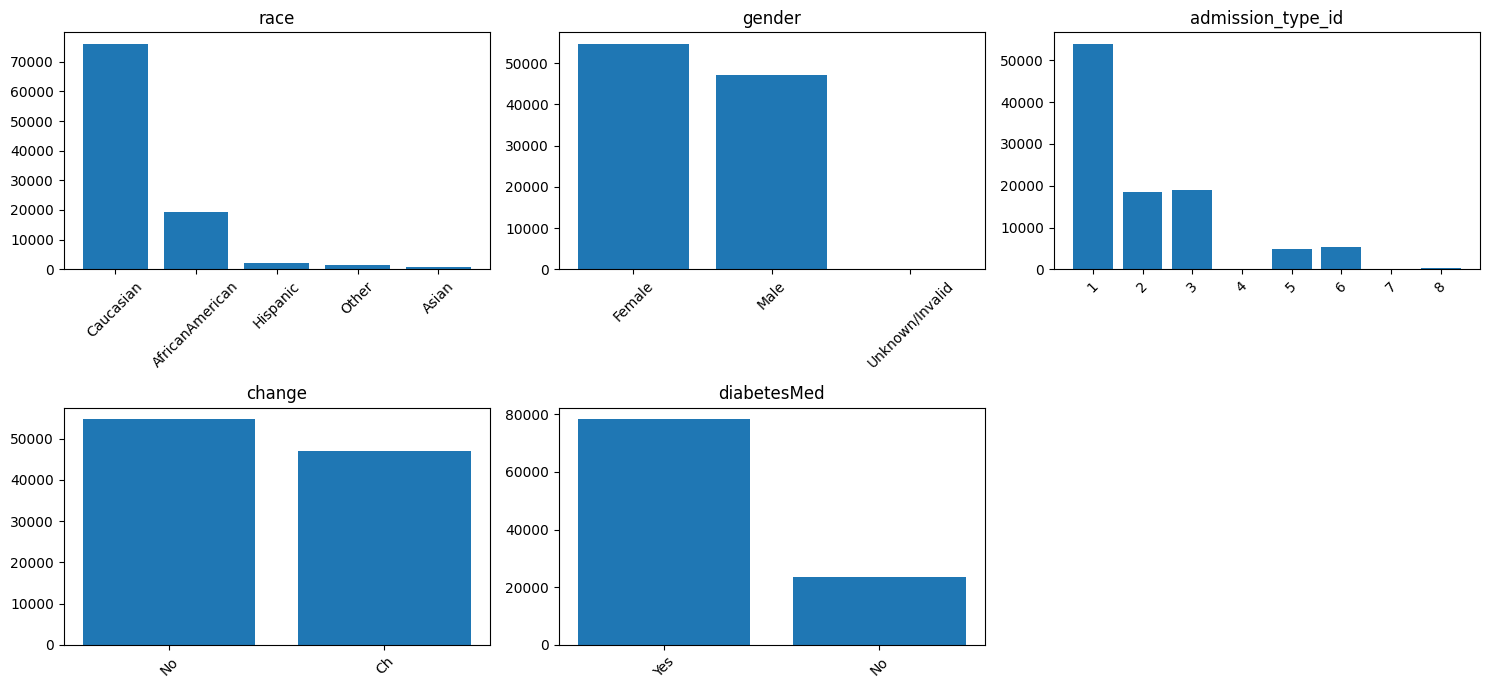

In [50]:
plt.figure(figsize=(15, 7))
for i, col in enumerate(plotable_cat_data):
    plt.subplot(2, 3, i + 1)
    plt.bar(cat_data[col].value_counts().index, cat_data[col].value_counts().values)
    plt.xticks(rotation=45)
    plt.title(col)

plt.tight_layout()
plt.show()

In [51]:
#The Chi-Square test is used to determine whether there is a significant association between two categorical variables.
chi2_results = {}
for col in CATEGORICAL_COLS:
    contingency_table = pd.crosstab(data[col], data['readmitted'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[col] = p
chi2_results = pd.Series(chi2_results)
print("Chi-Square Test Results (p-values):")
print(chi2_results)

# Hypothesis Testing Comments
# For each categorical feature, we perform the Chi-Square test to check for independence with the target variable 'readmitted'.
# Null Hypothesis (H0): There is no association between the categorical feature and the target variable.
# Alternative Hypothesis (H1): There is an association between the categorical feature and the target variable.

Chi-Square Test Results (p-values):
race                         6.741338e-19
gender                       1.899935e-08
age                          5.104671e-48
payer_code                   2.830245e-91
admission_type_id            4.373431e-79
discharge_disposition_id     0.000000e+00
admission_source_id         1.488750e-220
diag_1                       0.000000e+00
diag_2                      2.186857e-263
diag_3                      1.711820e-209
change                       9.964594e-49
diabetesMed                  1.169410e-85
dtype: float64


C:\Users\andre\AppData\Local\Temp\ipykernel_11060\3294115947.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cramers_v_results.values, y=cramers_v_results.index, palette=[bar_color]*len(cramers_v_results))


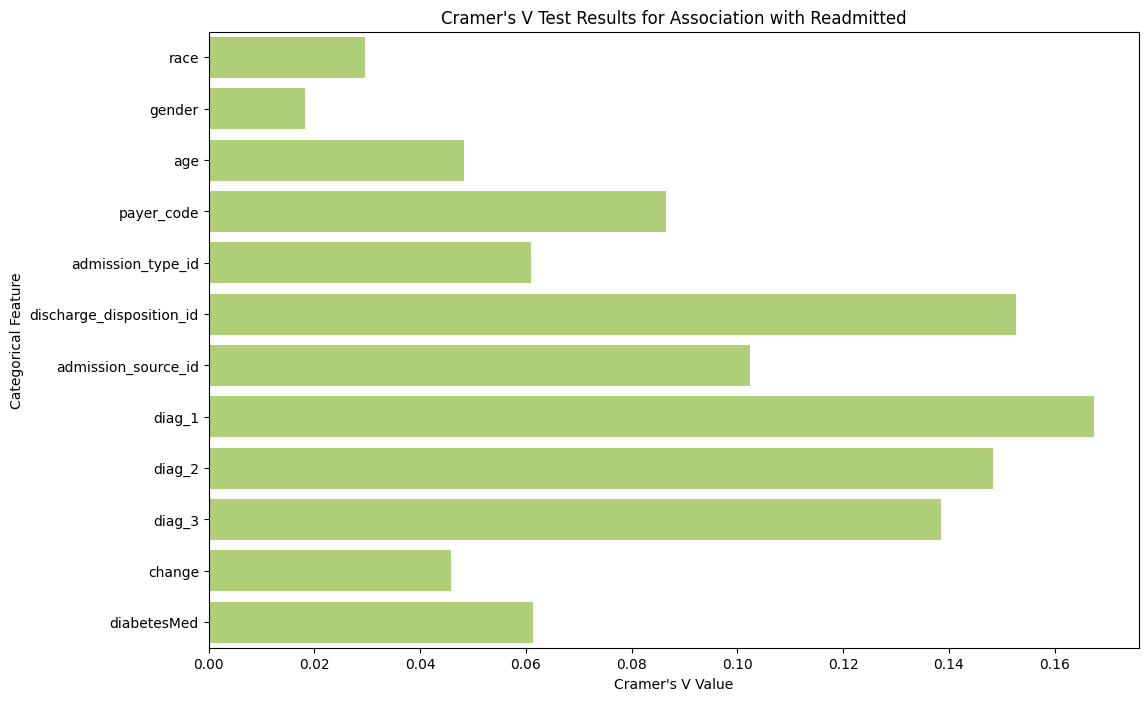

In [52]:
# Interpretation of Cramer's V Values
# Cramer's V is a measure of association between two nominal (categorical) variables.
# Values range from 0 to 1:
# - 0 indicates no association between the variables.
# - 1 indicates a perfect association between the variables.
# Interpretation of Cramer's V Values:
# - 0 to 0.1: Little to no association.
# - 0.1 to 0.3: Weak association.
# - 0.3 to 0.5: Moderate association.
# - 0.5 to 1.0: Strong association.
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_v_results = {}
for col in CATEGORICAL_COLS:
    confusion_matrix = pd.crosstab(data[col], data['readmitted'])
    cramers_v_results[col] = cramers_v(confusion_matrix)
cramers_v_results = pd.Series(cramers_v_results)
plt.figure(figsize=(12, 8))
sns.barplot(x=cramers_v_results.values, y=cramers_v_results.index, palette=[bar_color]*len(cramers_v_results))
plt.title("Cramer's V Test Results for Association with Readmitted")
plt.xlabel("Cramer's V Value")
plt.ylabel("Categorical Feature")
plt.show();

#### **Mixed-Data Analysis**

In [53]:
#  categories for numerical columns
hospital_stay_info = ['time_in_hospital']
procedures_info = ['num_lab_procedures', 'num_procedures']
medication_info = ['num_medications']
visit_info = ['number_outpatient', 'number_emergency', 'number_inpatient']
diagnosis_info = ['number_diagnoses']

numerical_categories = {
    'Hospital Stay Information': hospital_stay_info,
    'Procedures Information': procedures_info,
    'Medication Information': medication_info,
    'Visit Information': visit_info,
    'Diagnosis Information': diagnosis_info
}





Hospital Stay Information


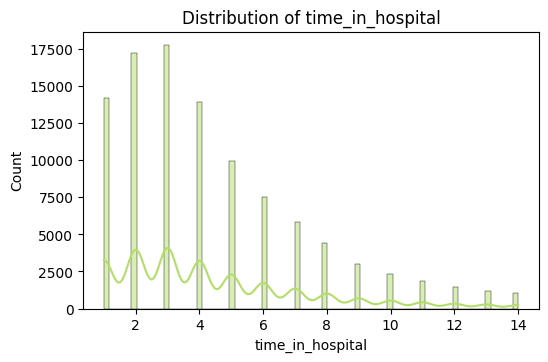



Procedures Information


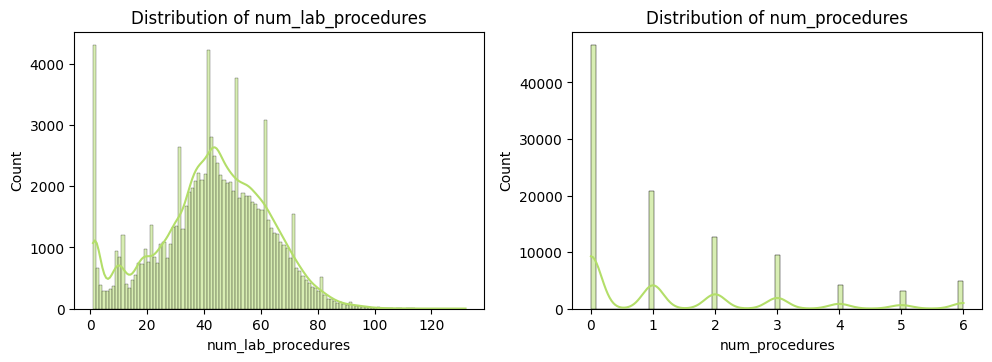



Medication Information


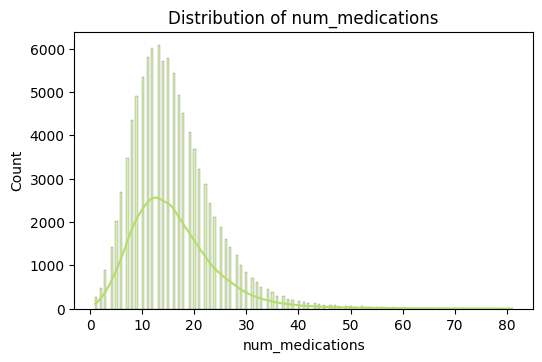



Visit Information


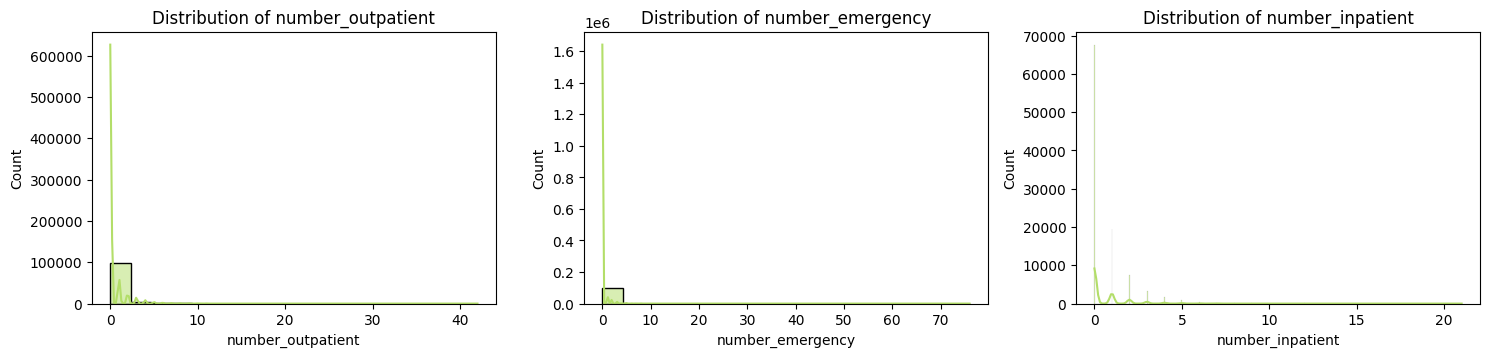



Diagnosis Information


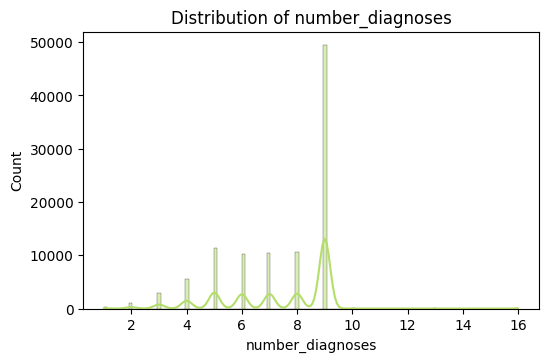

In [54]:
def plot_histograms(category_name, columns, color=bar_color):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(columns, 1):
        plt.subplot(3, 3, i)
        sns.histplot(data[col], kde=True, color=color)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()


for category, columns in numerical_categories.items():
    print(f"\n\n{category}")
    plot_histograms(category, columns)

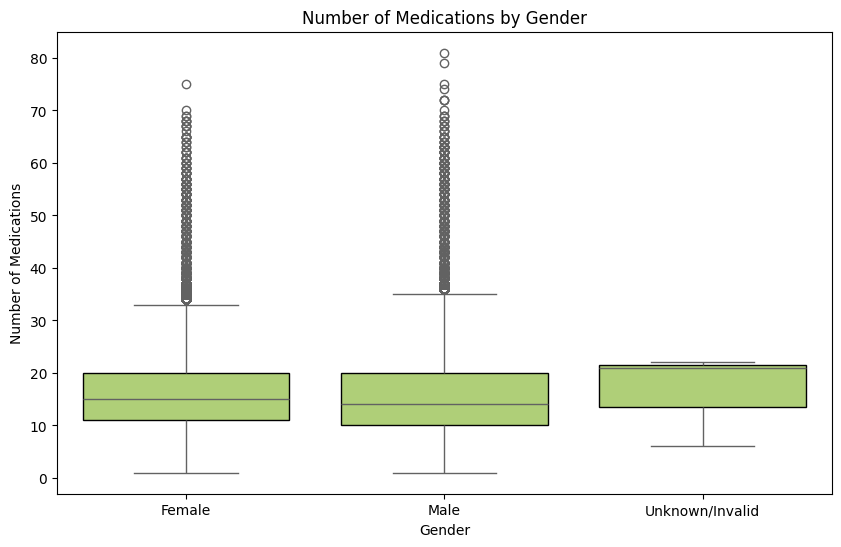

In [55]:
#Boxplot comparing number of medications by gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='num_medications', data=data,  color=bar_color, boxprops=dict(edgecolor='black'))
plt.title('Number of Medications by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Medications')
plt.show()

In [56]:
#Null Hypothesis (H0): There is no difference in the number of medications between the two groups (e.g., male and female patients).
#Alternative Hypothesis (H1): There is a difference in the number of medications between the two groups.

#  T-test comparing number of medications between two groups
group1 = data[data['gender'] == 'Male']['num_medications']
group2 = data[data['gender'] == 'Female']['num_medications']

t_stat, p_val = ttest_ind(group1, group2)
print(f"T-test results: t-statistic = {t_stat}, p-value = {p_val}")
#This means there is strong evidence to suggest a significant difference in the number of medications between the two groups

T-test results: t-statistic = -7.029213798239992, p-value = 2.0899986176857538e-12


In [57]:
# Define categories for categorical columns
demographic_info = ['race', 'gender', 'age']
admission_info = ['payer_code', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
diagnosis_info = ['diag_1', 'diag_2', 'diag_3']
treatment_info = ['change', 'diabetesMed']

# Combine all categories into a dictionary for easy access
categorical_categories = {
    'Demographic Information': demographic_info,
    'Admission Information': admission_info,
    'Treatment Information': treatment_info  # Excluding Diagnosis Information
}



Demographic Information


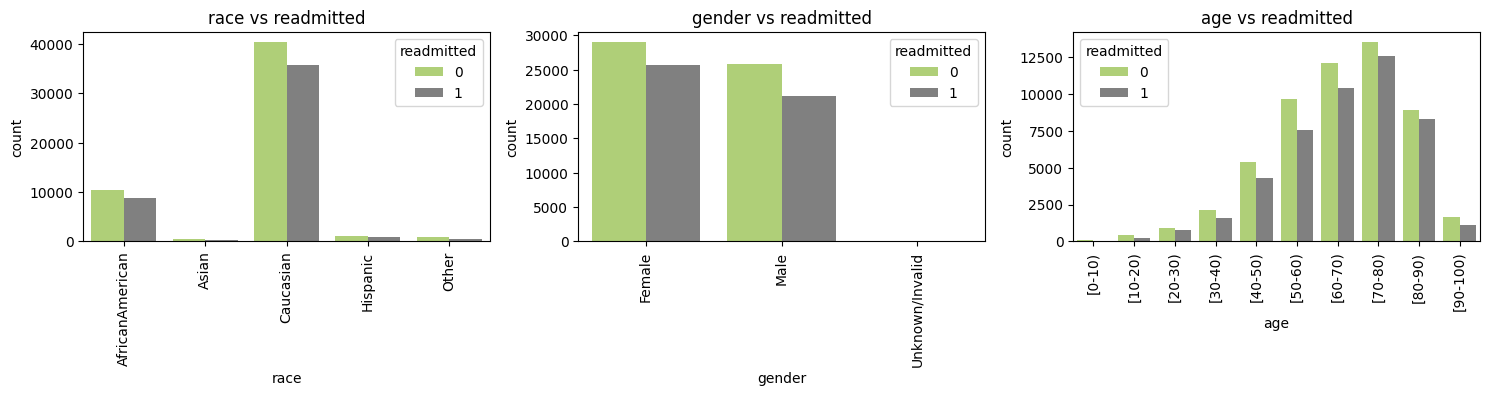



Admission Information


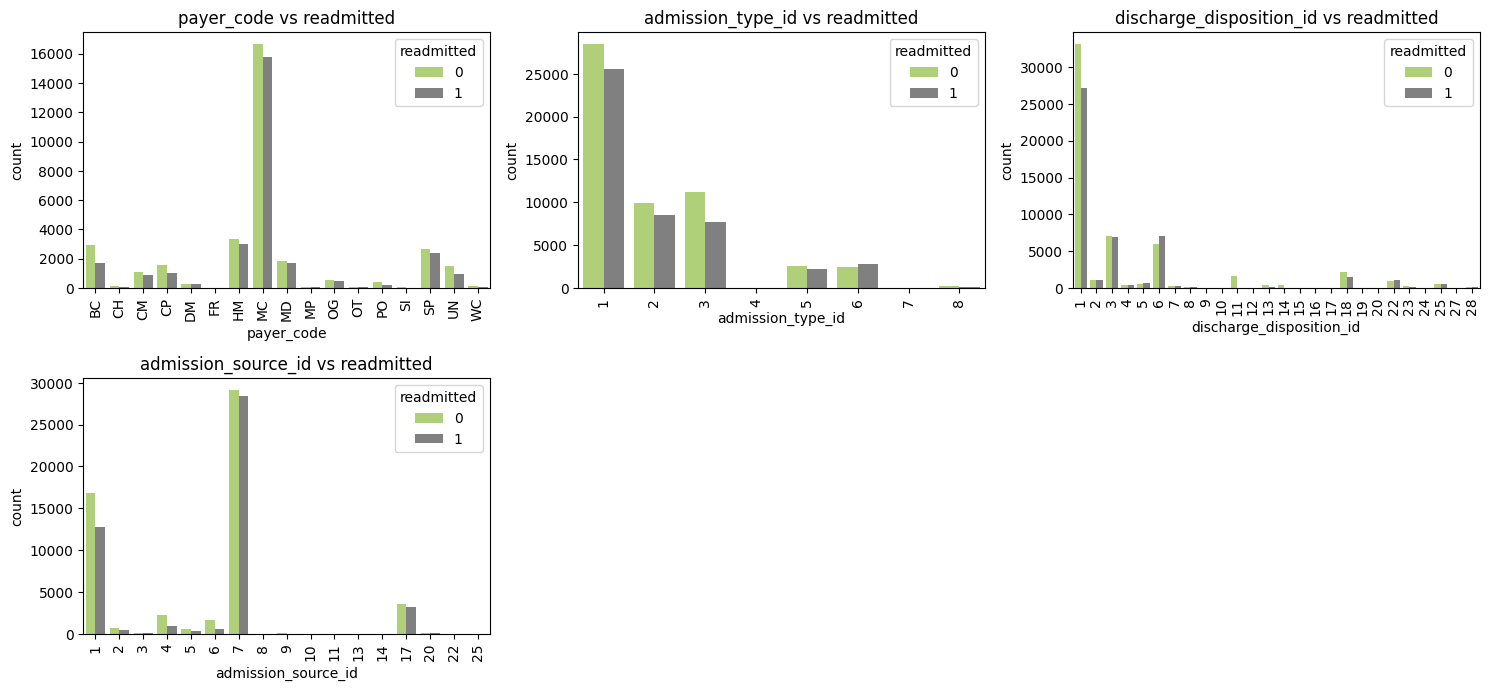



Treatment Information


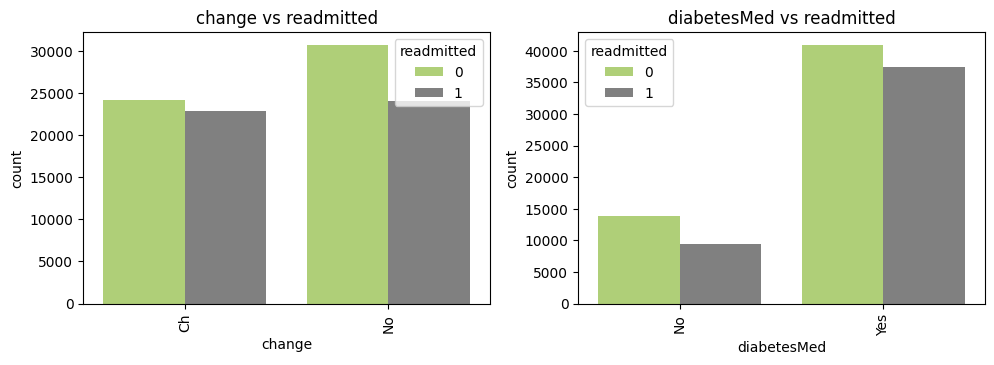

In [58]:
bar_color = '#b3de69'
second_bar_color = 'grey'

def plot_bar_plots(category_name, columns, target='readmitted'):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(columns, 1):
        plt.subplot(3, 3, i)
        sns.countplot(x=col, hue=target, data=data, palette=[bar_color, second_bar_color])
        plt.title(f'{col} vs {target}')
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Plot bar plots for each category
for category, columns in categorical_categories.items():
    print(f"\n\n{category}")
    plot_bar_plots(category, columns)